In [1]:
import os
import argparse
from utils import *
from tqdm import tqdm
from torch import optim
from model import my_model
import torch.nn.functional as F
import pandas as pd
from utils import get_logger
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
import os
import scipy.sparse as sparse
import anndata
import seaborn as sns
import time
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3 
sns.set_style("white")
np.random.seed(0)

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==1.24.1 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [2]:
# parameters setting
cluster_num =7
gnnlayers = 3
lr = 1e-3
dims = [200]
epochs=400
sigma=0.01

In [4]:
section_id = "151675"
input_dir = os.path.join('F:\\王海月\\代码\\UGIMC\\Data\\', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]  

reading F:\王海月\代码\UGIMC\Data\151675\151675_filtered_feature_bc_matrix.h5
 (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


In [5]:
Ann_df = pd.read_csv(os.path.join('F:\\王海月\\代码\\UGIMC\\Data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

In [6]:
from image_feature import ImageFeature, image_crop
from pathlib import Path
save_path = 'results'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section_id}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)
adata = image_crop(adata, crop_size=112, save_path=save_path_image_crop, verbose=False)
adata = ImageFeature(adata, pca_components=200, verbose=True, seeds=2023).extract_image_features()
adata

Tiling Image: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The image feature is added to adata.obsm['Image_Feature']
The pca result of image features is added to adata.obsm['image_feat_pca']


AnnData object with n_obs × n_vars = 3592 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Ground Truth', 'image_col', 'image_row', 'slice_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial', 'image_feature', 'aug_image_feature1', 'aug_image_feature2', 'image_feat_pca'

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.48765039443969727 seconds
Jaccard graph constructed in 3.9924957752227783 seconds
Wrote graph to binary file in 0.060285329818725586 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.862324
After 4 runs, maximum modularity is Q = 0.863423
After 16 runs, maximum modularity is Q = 0.864585
Louvain completed 36 runs in 4.415062665939331 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 11.561462163925171 seconds


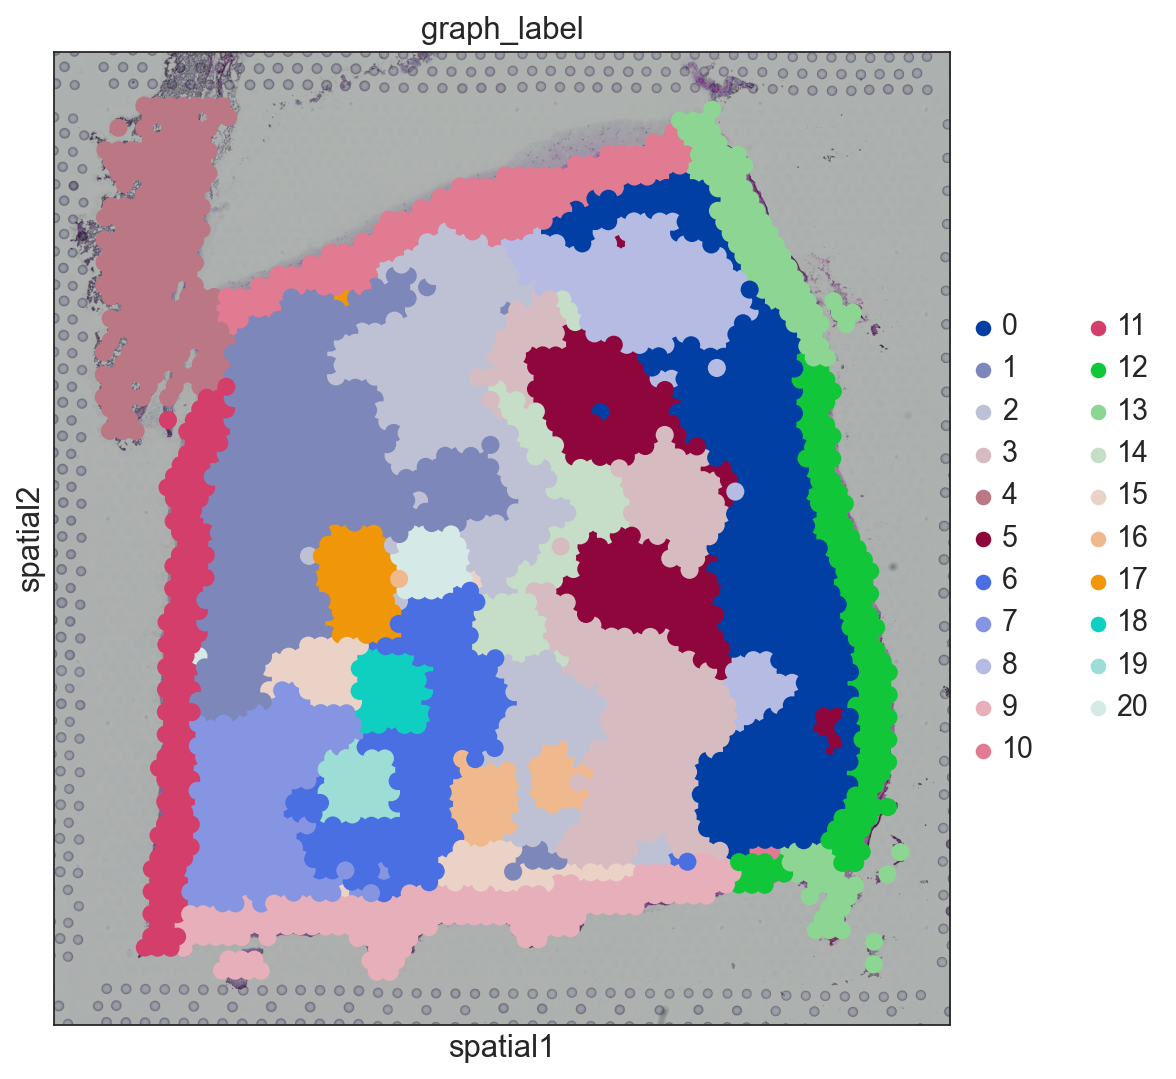

In [8]:
import phenograph
graph_label, _, _ = phenograph.cluster(adata.obsm['image_feat_pca'])
adata.obs['graph_label'] = graph_label
adata.obs['graph_label'] = adata.obs['graph_label'].astype('category')
sc.pl.spatial(adata, color='graph_label', size=2)

In [9]:
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score 
ARI = adjusted_rand_score(adata.obs['graph_label'], pd.Categorical(adata.obs['Ground Truth']).codes)
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.23


In [10]:
from sklearn.metrics import pairwise_distances
morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

In [11]:
n_spot = len(adata.obs['graph_label'] )
n_neighbor = 8
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering
morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_network = np.zeros((n_spot, n_spot))
for i in range(n_spot):
    vec = morphological_similarity[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(n_neighbor + 1):
        y = distance[t]
        morphological_network[i, y] = morphological_similarity[i, y]

In [12]:
n_clusters = 7  
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels = spectral.fit_predict(morphological_network)
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score 
ARI = adjusted_rand_score(labels, pd.Categorical(adata.obs['Ground Truth']).codes)
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.22


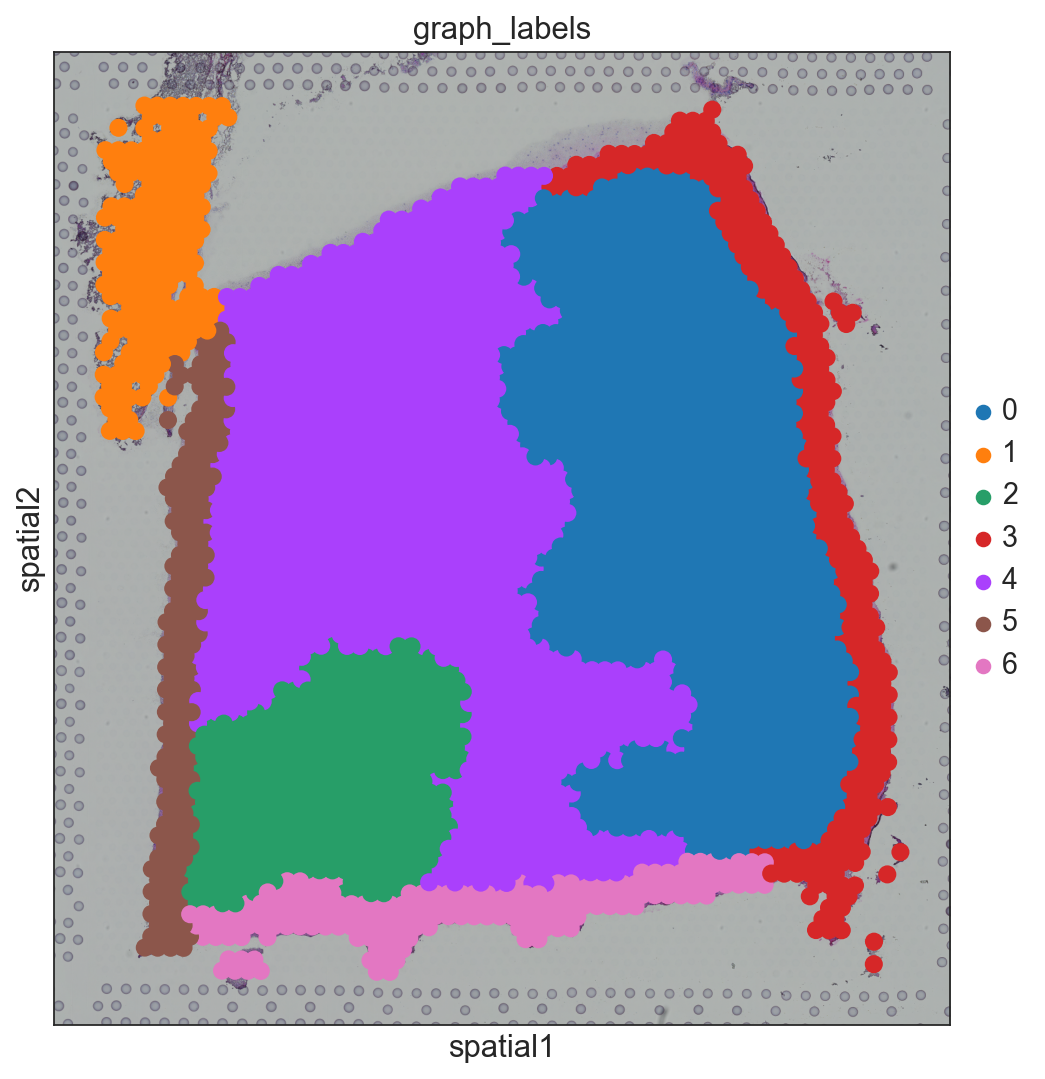

In [13]:
adata.obs['graph_labels'] = labels
adata.obs['graph_labels'] = adata.obs['graph_labels'].astype('category')
sc.pl.spatial(adata, color='graph_labels', size=2)

In [14]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6, ratio=0.2)
feat = np.array(enhanced_adata.X)
adj = cell_spatial.A
true_labels = pd.Categorical(adata.obs['Ground Truth']).codes


Median distance to closest cell = 138.00362314084367
num_nbrs: 3000


In [15]:
features = feat
adj = sp.csr_matrix(adj)
adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj.eliminate_zeros()
print('Laplacian Smoothing...')
adj_norm_s = preprocess_graph(adj, gnnlayers, norm='sym', renorm=True)
sm_fea_s = features
for a in adj_norm_s:
    sm_fea_s = a.dot(sm_fea_s)
sm_fea_s = torch.FloatTensor(sm_fea_s)
adj_1st = (adj + sp.eye(adj.shape[0])).toarray()
acc_list = []
nmi_list = []
ari_list = []
f1_list = []
best_acc=0
best_nmi=0
best_ari=0
best_f1=0
device='cpu'
logger = get_logger()
for seed in range(1):
    setup_seed(seed)
    best_accs, best_nmis, best_aris, best_f1s, prediect_labels = clustering(sm_fea_s, true_labels, cluster_num)
    print(best_ari)
    model = my_model([features.shape[1]] + dims)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)
    inx = sm_fea_s.to(device)
    target = torch.FloatTensor(adj_1st).to(device)
    criterion = torch.nn.MSELoss(reduction='sum')

    print('Start Training...')
    logger.info('--------------------Start Training--------------------')
    for epoch in tqdm(range(epochs)):
        model.train()
        z1, z2,decoder_out= model(inx, is_train=True, sigma=sigma)
        S = z1 @ z2.T
        loss = 0.1 * F.mse_loss(S, target) + criterion(decoder_out, inx) #+ criterion(decoder_out2, inx)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            model.eval()
            z1, z2,decoder_out = model(inx, is_train=False, sigma=sigma)
            hidden_emb = (z1 + z2) / 2

            acc, nmi, ari, f1, predict_labels = clustering(hidden_emb, true_labels, cluster_num)
            if ari >= best_ari:
                best_acc = acc
                best_nmi = nmi
                best_ari = ari
                best_f1 = f1
                best_label = predict_labels
                best_h = hidden_emb.detach().numpy()
                df_S = pd.DataFrame(S.detach().numpy())
                df_l = pd.DataFrame(best_label)
                df_X = pd.DataFrame(decoder_out.detach().numpy())


    logger.info('--------------------Training over--------------------')
    logger.info(
        """ ACC {:.2f} NMI {:.2f} ARI {:.2f} f_score {:.2f} """.format(best_acc, best_nmi, best_ari, best_f1))
    print(best_acc, best_nmi, best_ari, best_f1)
    enhanced_adata.obsm['denoised']=decoder_out.detach().numpy()
    enhanced_adata.obs['stMuGC_label']=best_label
    enhanced_adata.obsm['feature']=hidden_emb.detach().numpy()
    enhanced_adata.obsm['S']=S.detach().numpy()

Laplacian Smoothing...
<class 'torch.Tensor'>


2025-04-15 16:58:33 - root - INFO: - --------------------Start Training--------------------


0
Start Training...


  0%|                                                                                                                                                                                                          | 0/400 [00:00<?, ?it/s]

<class 'torch.Tensor'>


  2%|████▊                                                                                                                                                                                            | 10/400 [00:06<03:32,  1.84it/s]

<class 'torch.Tensor'>


  5%|█████████▋                                                                                                                                                                                       | 20/400 [00:12<03:41,  1.72it/s]

<class 'torch.Tensor'>


  8%|██████████████▍                                                                                                                                                                                  | 30/400 [00:19<03:28,  1.77it/s]

<class 'torch.Tensor'>


 10%|███████████████████▎                                                                                                                                                                             | 40/400 [00:25<03:20,  1.79it/s]

<class 'torch.Tensor'>


 12%|████████████████████████▏                                                                                                                                                                        | 50/400 [00:31<03:07,  1.86it/s]

<class 'torch.Tensor'>


 15%|████████████████████████████▉                                                                                                                                                                    | 60/400 [00:37<03:26,  1.64it/s]

<class 'torch.Tensor'>


 18%|█████████████████████████████████▊                                                                                                                                                               | 70/400 [00:44<03:47,  1.45it/s]

<class 'torch.Tensor'>


 20%|██████████████████████████████████████▌                                                                                                                                                          | 80/400 [00:50<03:11,  1.67it/s]

<class 'torch.Tensor'>


 22%|███████████████████████████████████████████▍                                                                                                                                                     | 90/400 [00:57<02:52,  1.79it/s]

<class 'torch.Tensor'>


 25%|████████████████████████████████████████████████                                                                                                                                                | 100/400 [01:02<02:30,  1.99it/s]

<class 'torch.Tensor'>


 28%|████████████████████████████████████████████████████▊                                                                                                                                           | 110/400 [01:08<02:27,  1.96it/s]

<class 'torch.Tensor'>


 30%|█████████████████████████████████████████████████████████▌                                                                                                                                      | 120/400 [01:14<02:21,  1.98it/s]

<class 'torch.Tensor'>


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                 | 130/400 [01:20<02:30,  1.80it/s]

<class 'torch.Tensor'>


 35%|███████████████████████████████████████████████████████████████████▏                                                                                                                            | 140/400 [01:26<02:10,  1.99it/s]

<class 'torch.Tensor'>


 38%|████████████████████████████████████████████████████████████████████████                                                                                                                        | 150/400 [01:32<02:07,  1.96it/s]

<class 'torch.Tensor'>


 40%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 160/400 [01:38<02:10,  1.84it/s]

<class 'torch.Tensor'>


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 170/400 [01:43<01:58,  1.95it/s]

<class 'torch.Tensor'>


 45%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 180/400 [01:49<01:57,  1.88it/s]

<class 'torch.Tensor'>


 48%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 190/400 [01:55<01:49,  1.92it/s]

<class 'torch.Tensor'>


 50%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 200/400 [02:01<01:47,  1.86it/s]

<class 'torch.Tensor'>


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 210/400 [02:07<01:37,  1.96it/s]

<class 'torch.Tensor'>


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 220/400 [02:13<01:31,  1.98it/s]

<class 'torch.Tensor'>


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 230/400 [02:19<01:30,  1.87it/s]

<class 'torch.Tensor'>


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 240/400 [02:25<01:20,  1.98it/s]

<class 'torch.Tensor'>


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 250/400 [02:31<01:16,  1.95it/s]

<class 'torch.Tensor'>


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 260/400 [02:36<01:09,  2.02it/s]

<class 'torch.Tensor'>


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 270/400 [02:42<01:07,  1.94it/s]

<class 'torch.Tensor'>


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 280/400 [02:48<01:00,  2.00it/s]

<class 'torch.Tensor'>


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 290/400 [02:53<00:55,  1.99it/s]

<class 'torch.Tensor'>


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 300/400 [02:59<00:50,  1.97it/s]

<class 'torch.Tensor'>


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 310/400 [03:05<00:47,  1.91it/s]

<class 'torch.Tensor'>


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 320/400 [03:10<00:41,  1.94it/s]

<class 'torch.Tensor'>


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 330/400 [03:15<00:34,  2.04it/s]

<class 'torch.Tensor'>


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 340/400 [03:21<00:29,  2.03it/s]

<class 'torch.Tensor'>


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 350/400 [03:26<00:25,  1.98it/s]

<class 'torch.Tensor'>


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 360/400 [03:32<00:20,  1.91it/s]

<class 'torch.Tensor'>


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 370/400 [03:37<00:15,  1.92it/s]

<class 'torch.Tensor'>


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 380/400 [03:43<00:10,  1.94it/s]

<class 'torch.Tensor'>


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 390/400 [03:49<00:05,  1.96it/s]

<class 'torch.Tensor'>


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [03:54<00:00,  1.70it/s]
2025-04-15 17:02:28 - root - INFO: - --------------------Training over--------------------
2025-04-15 17:02:28 - root - INFO: -  ACC 69.54 NMI 72.52 ARI 62.60 f_score 55.99 


69.54 72.52 62.6 55.99


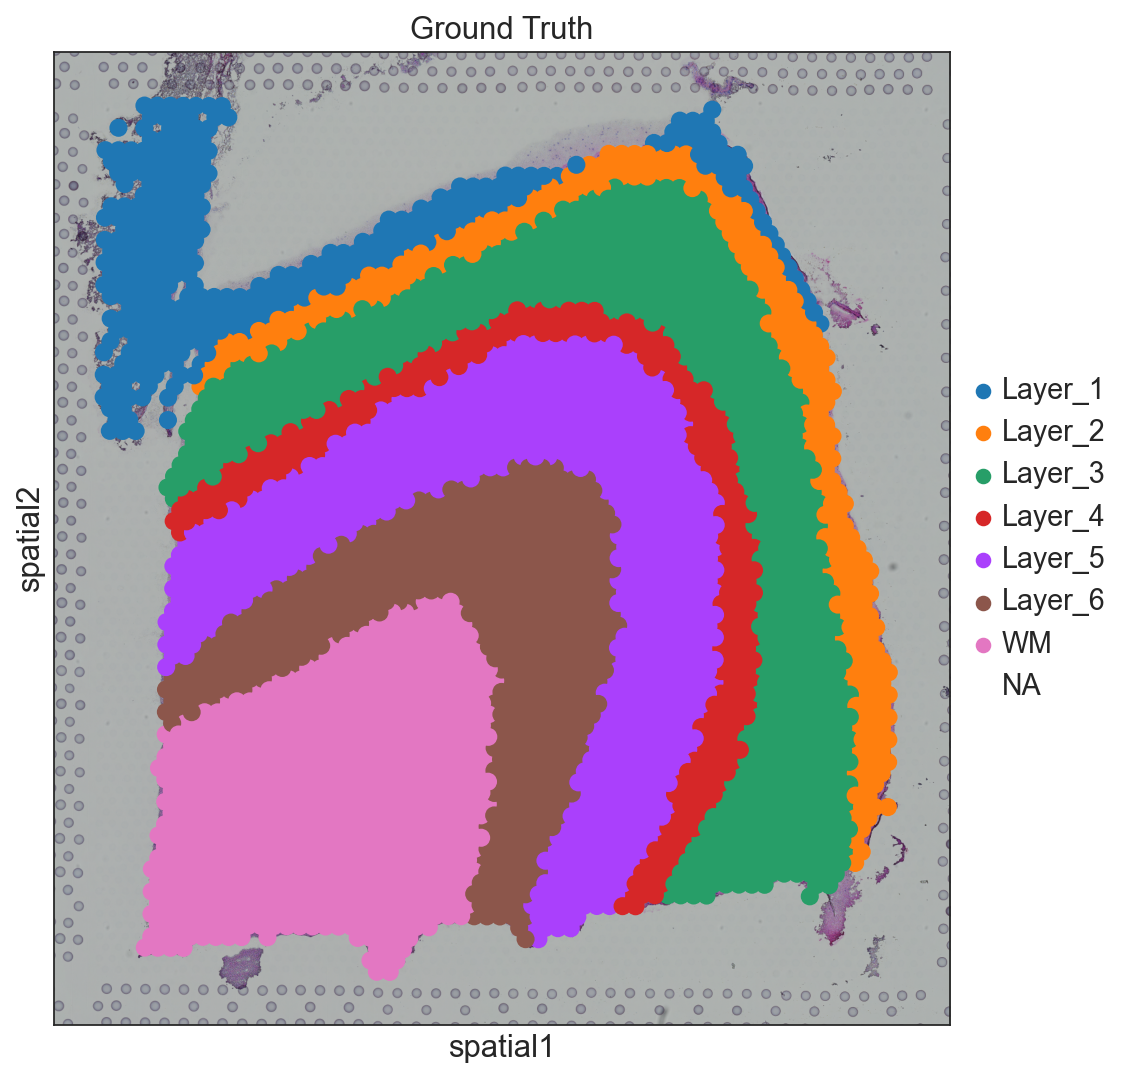

In [16]:
sc.pl.spatial(adata, color='Ground Truth', size=2)

... storing 'stMuGC_label' as categorical


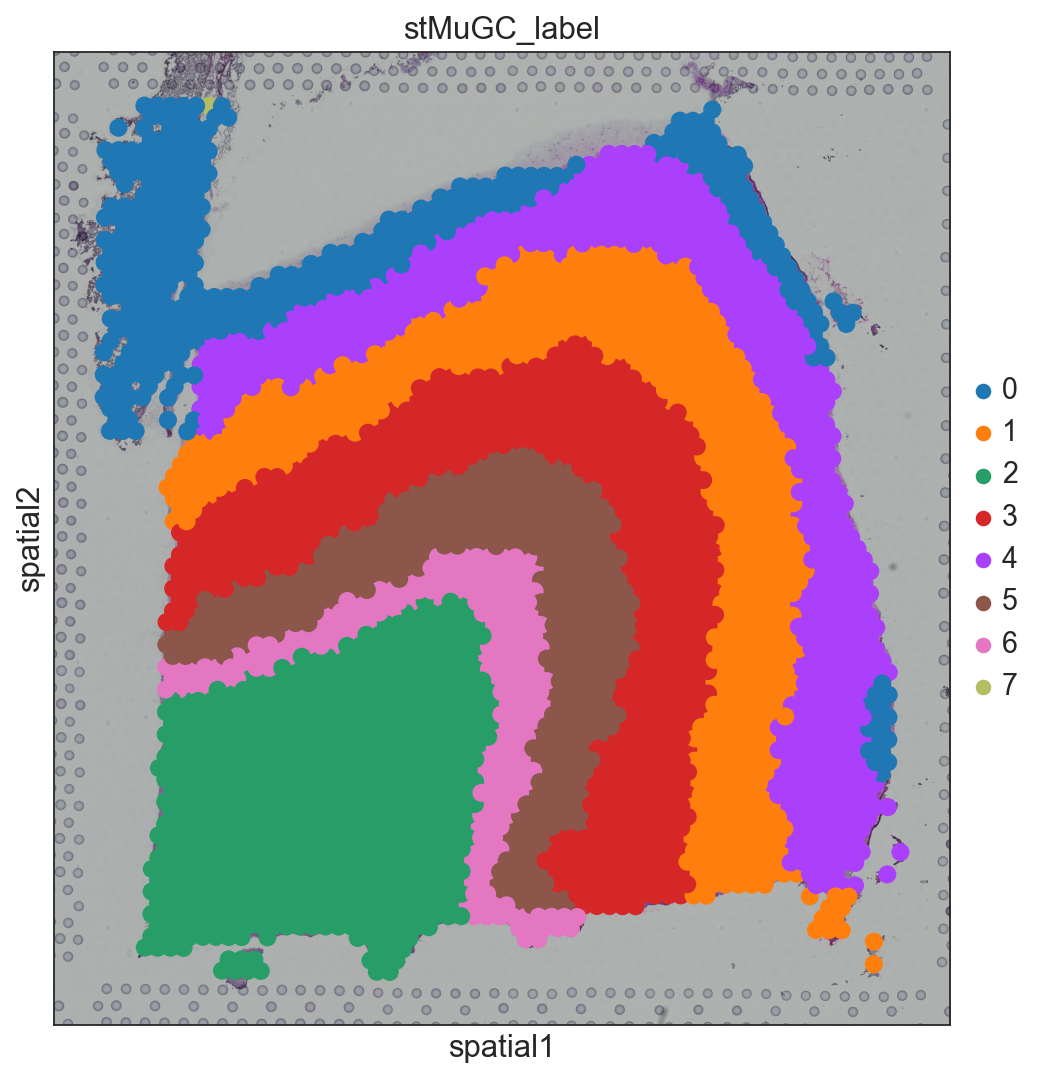

In [17]:
adata.obs['stMuGC_label']=best_label.astype(str)
sc.pl.spatial(adata, color='stMuGC_label', size=2)

In [18]:
ARI = adjusted_rand_score(best_label, pd.Categorical(enhanced_adata.obs['Ground Truth']).codes)
print('Adjusted rand index = %.3f' %ARI)

Adjusted rand index = 0.626


In [19]:
denoised_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6, ratio=0.2)
denoised_adata.X = enhanced_adata.obsm['denoised']
denoised_adata.obs["Ground Truth"]=enhanced_adata.obs["Ground Truth"]
denoised_adata.obs['stMuGC_label']=best_label
denoised_adata.obsm['feature']=hidden_emb.detach().numpy()
denoised_adata.obsm['S']=S.detach().numpy()


Median distance to closest cell = 138.00362314084367
num_nbrs: 3000


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


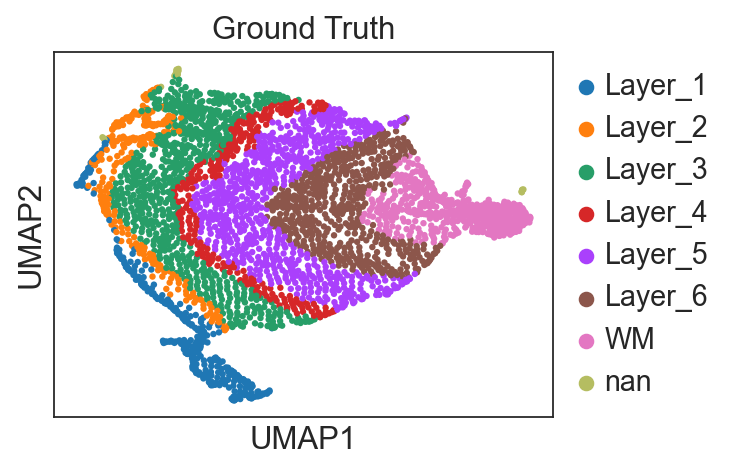

In [23]:
sc.pp.neighbors(denoised_adata)
sc.tl.umap(denoised_adata)
sc.pl.umap(denoised_adata, color=[ "Ground Truth"])

In [24]:
denoised_adata.obs['Ground Truth'] = denoised_adata.obs['Ground Truth'].astype('str')
denoised_adata.obs['Ground Truth'] = denoised_adata.obs['Ground Truth'].astype('category')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


2025-04-15 17:17:17 - matplotlib.backends.backend_pdf - DEBUG: - Assigning font /F1 = 'C:\\Windows\\Fonts\\arial.ttf'
2025-04-15 17:17:17 - matplotlib.backends.backend_pdf - DEBUG: - Embedding font C:\Windows\Fonts\arial.ttf.
2025-04-15 17:17:17 - matplotlib.backends.backend_pdf - DEBUG: - Writing TrueType font.


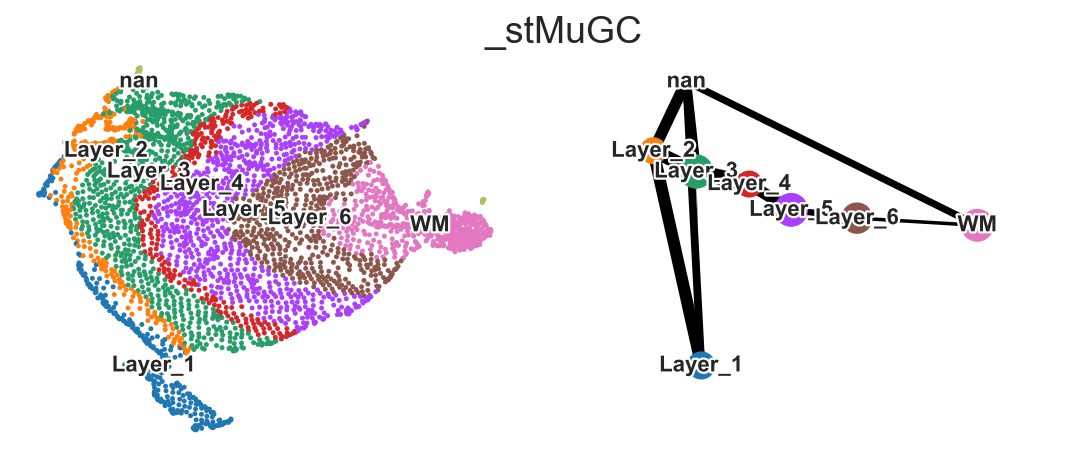

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

In [25]:
sc.tl.paga(denoised_adata, groups='Ground Truth')
plt.rcParams["figure.figsize"] = (4,3)
sc.pl.paga_compare(denoised_adata, legend_fontsize=10, frameon=False, size=20,
                   title='_stMuGC', legend_fontoutline=2,save='151675_stMuGC')